In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy as scipy
from scipy import interpolate
import os

In [2]:
#####################ppm config#####################
sample_point = 2048
BW = 2000#Hz
B = 127#3T = 3*42.58= 127MHz
ppm_length = BW/B#16.xx ppm
ppm_center = 4.7

min_bound = ppm_center - (ppm_length)/2
max_bound = ppm_center + (ppm_length)/2
ppm = np.linspace(min_bound, max_bound, sample_point)
ppm = ppm[::-1]#reverse
#####################ppm config#####################
#pos = np.where((ppm>=0.5) & (ppm<=4.5))
pos = np.where((ppm>=ppm.min()) & (ppm<=ppm.max()))
crop_ppm = ppm[pos]
print('ppm',len(crop_ppm))
print('ppm',crop_ppm[0]-crop_ppm[1])
#crop_filted_sdata = filted_sdata[pos]

ppm 2048
ppm 0.007693224961435874


C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


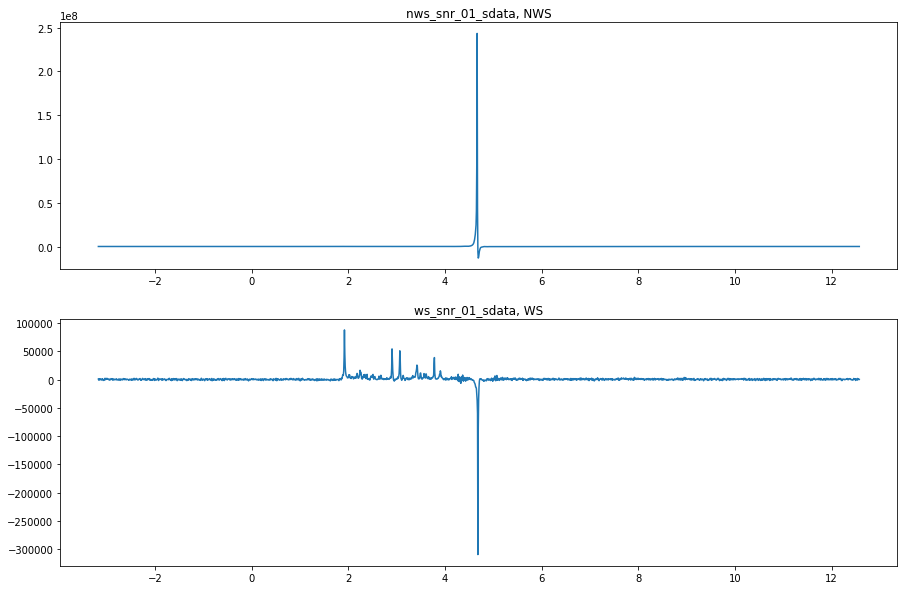

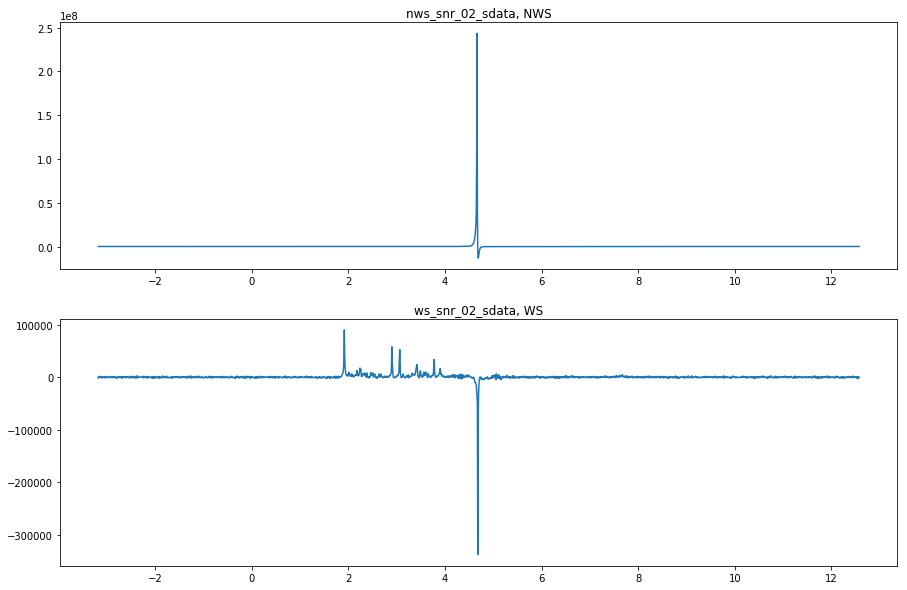

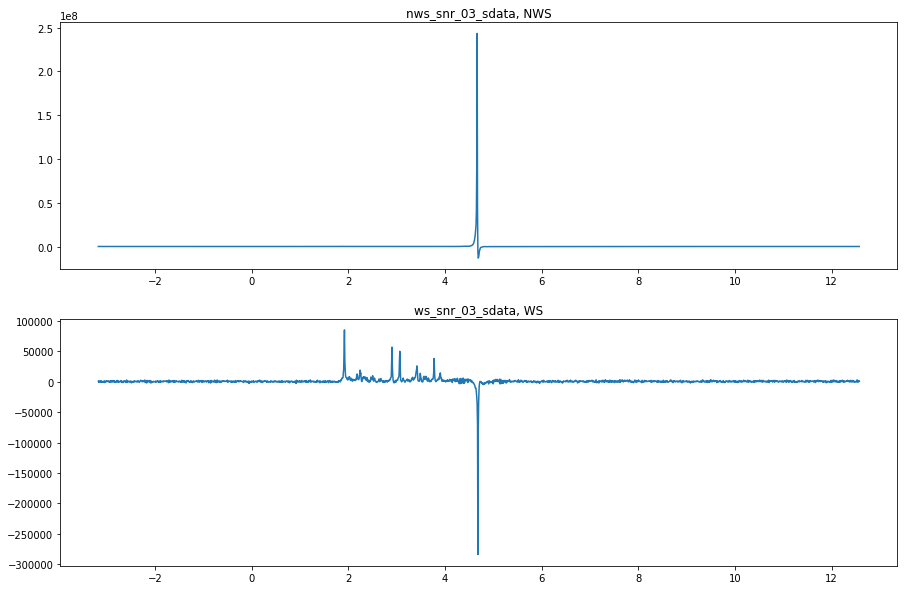

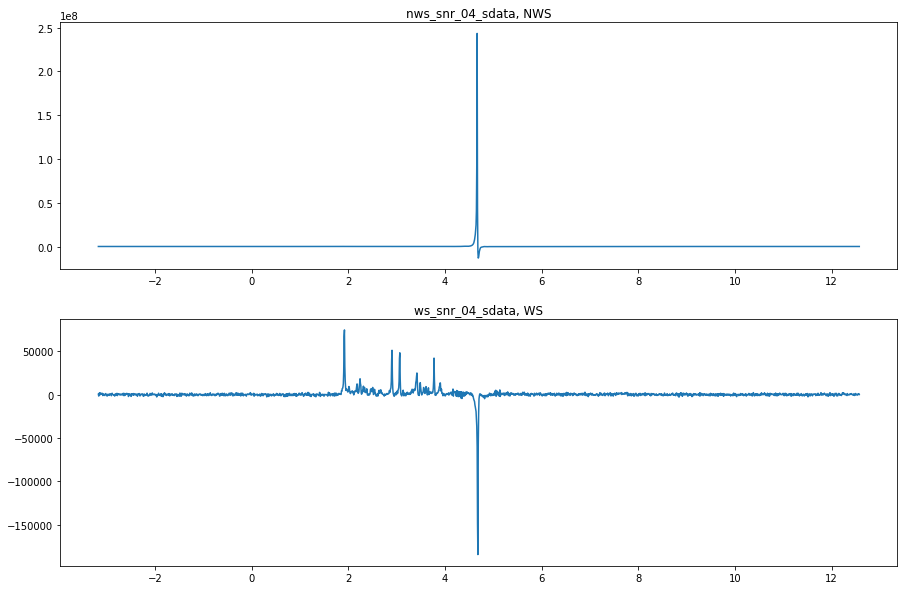

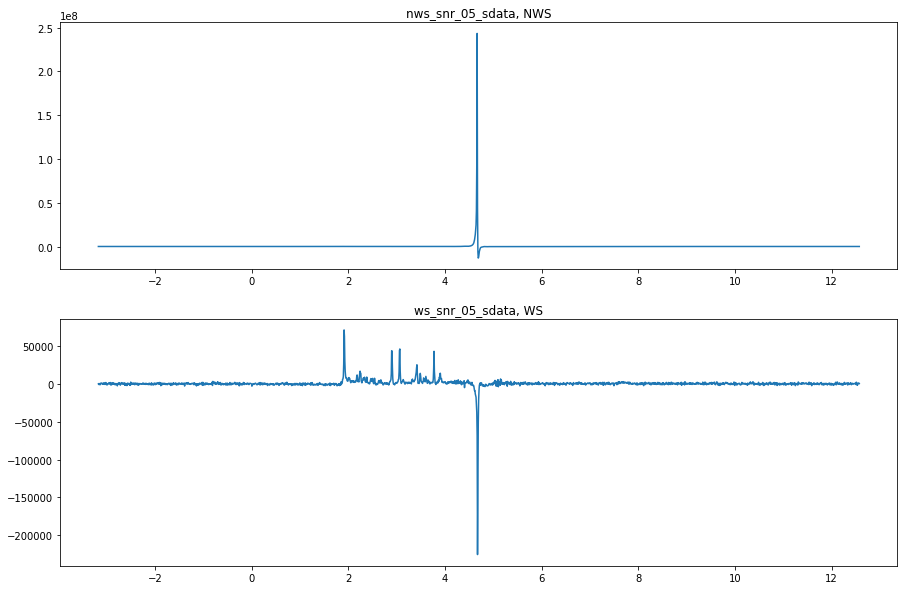

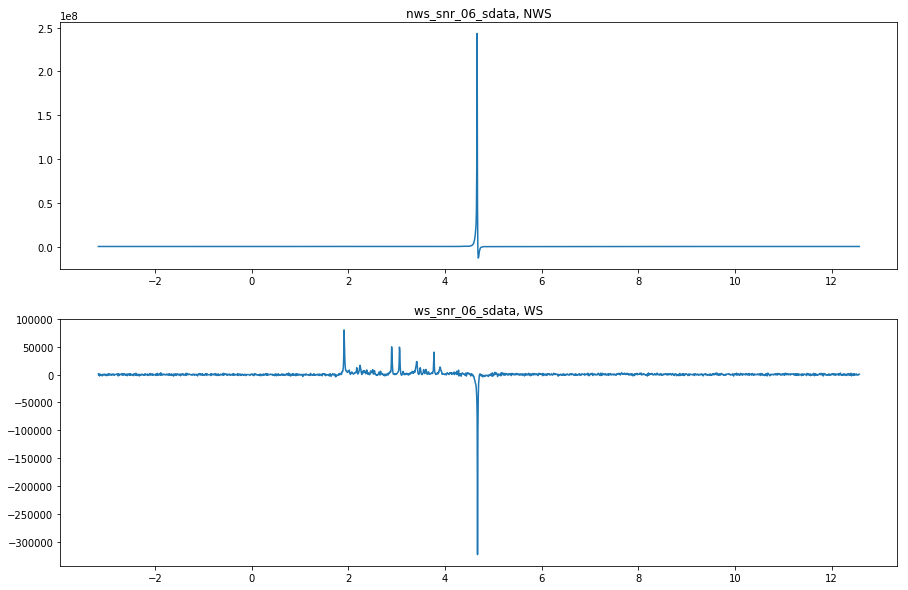

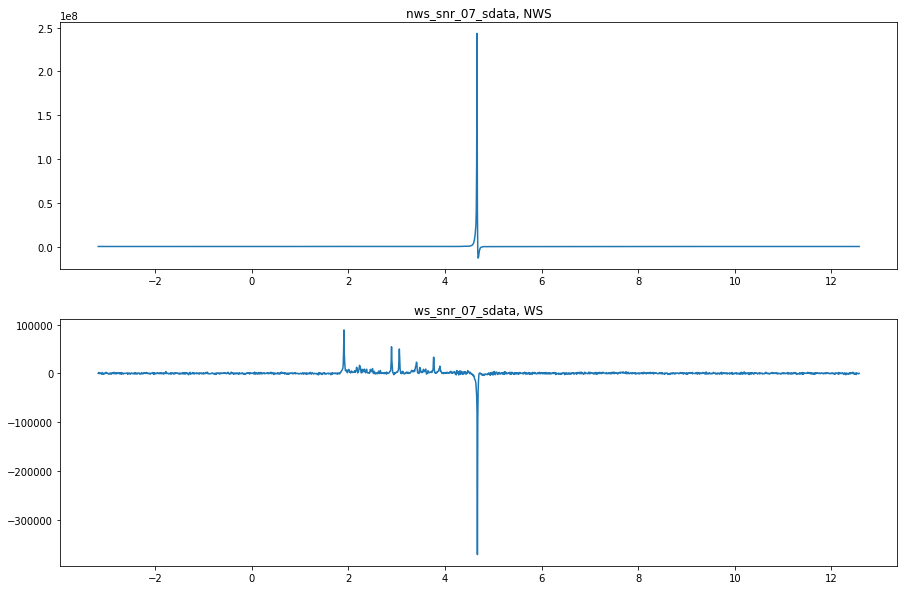

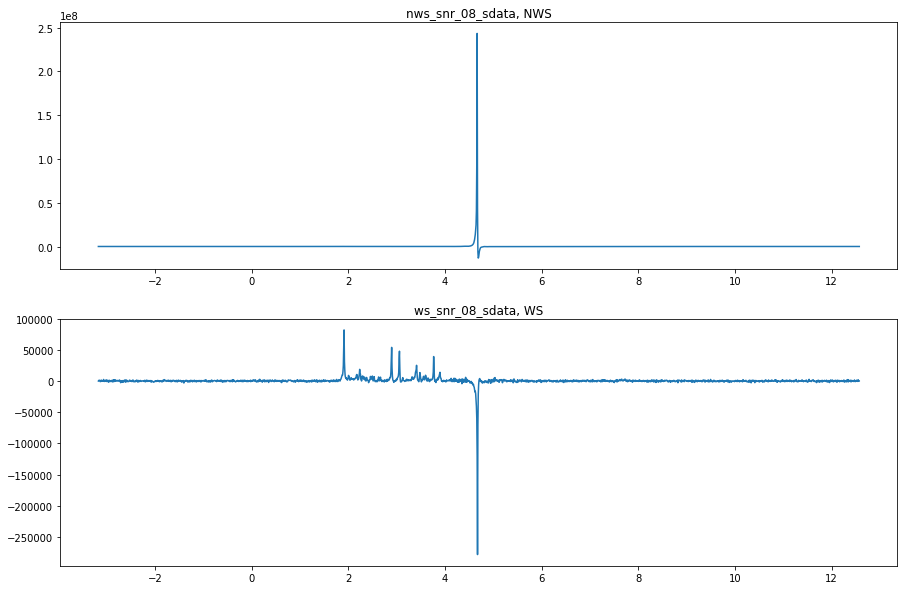

In [55]:
working_dir = os.getcwd()
phantom_path = os.path.join(working_dir,'phantom')
files = os.listdir(phantom_path)

for idx in files:
    snr_x_path =  os.path.join(phantom_path,idx)
    snr_x_nws_path = os.path.join(snr_x_path,'nws')
    snr_x_ws_path = os.path.join(snr_x_path,'ws')
    nws_data = loadmat(os.path.join(snr_x_nws_path,'meas_svs.mat'))
    nws_tdata = nws_data['tdata']
    nws_sdata = nws_data['sdata'][pos]

    ws_data = loadmat(os.path.join(snr_x_ws_path,'meas_svs.mat'))
    ws_tdata = ws_data['tdata']
    ws_sdata = (ws_data['sdata'][pos])

    plt.figure(figsize=(15,10))
    plt.subplot(211)
    plt.title(f'nws_{idx}_sdata, NWS')#WS
    plt.plot(crop_ppm,nws_sdata)#(2048,)
    #plt.xlim((5,4.5))

    plt.subplot(212)    
    plt.title(f'ws_{idx}_sdata, WS')#WS
    plt.plot(crop_ppm,ws_sdata)#(2048,)
    #plt.xlim((2.1,1.7))


## Dump files

In [38]:
def measure_width_hz(ppm, spectrum_data):
    if (spectrum_data.ndim == 2):
        spectrum_data = spectrum_data[:,0]
    tNAA_pos = np.where((ppm>=1.8) & (ppm<=2.2))
    tNAA_crop = spectrum_data[tNAA_pos]
    tNAA_FWHM_val = max(tNAA_crop)*0.2
    #tNAA_FWHM_val = max(tNAA_crop)*(1-0.707)
    tNAA_FWHM = np.where(tNAA_crop > tNAA_FWHM_val)
    tNAA_FWHM_width_ppm = max(ppm[tNAA_pos][tNAA_FWHM])-min(ppm[tNAA_pos][tNAA_FWHM])
    #ppm to Hz, (BW)/(total ppm = BW/B) * width_ppm = B*width_ppm
    tNAA_FWHM_width_hz = round(123.177*tNAA_FWHM_width_ppm, 3)
    return tNAA_FWHM_width_hz
#print('measure_width_hz',measure_width_hz(ppm, avg_ws_datasets_val))

def freq_shift_corr(ppm, spectrum_data):
    #print('spectrum_data.shape',spectrum_data.shape)
    tNAA_pos = np.where((ppm>=1.5) & (ppm<=2.5))
    NAA_peak_pos = np.array(np.where((spectrum_data == max(spectrum_data[tNAA_pos]))))[0]
    if len(NAA_peak_pos) > 1:
        NAA_peak_pos = int(NAA_peak_pos[0])
    ppm_2 = (np.abs(ppm - 2.0)).argmin()#The number was the cloest one to 2 ppm
    diff = NAA_peak_pos - ppm_2
    shift_point = NAA_peak_pos - ppm_2
    shift_correction = np.roll(spectrum_data,-shift_point)
    return shift_correction

working_dir = os.getcwd()
phantom_path = os.path.join(working_dir,'phantom')
files = os.listdir(phantom_path)
dump_path = os.path.join(working_dir,'phantom_to_model')

avg_ws_datasets = np.zeros([2048,],dtype=np.clongdouble)
print('avg_ws_datasets',avg_ws_datasets.shape)

for count,idx in enumerate(files):
    snr_x_path =  os.path.join(phantom_path,idx)
    snr_x_ws_path = os.path.join(snr_x_path,'ws')
    print('count',count)
    if (count == 0):
        snr_x_nws_path = os.path.join(snr_x_path,'nws')
        nws_data = loadmat(os.path.join(snr_x_nws_path,'meas_svs.mat'))
        nws_sdata = freq_shift_corr(ppm, nws_data['sdata'])[:,0]
        print('nws_sdata',nws_sdata.shape)
        np.savez(os.path.join(dump_path, 'nws_data'), X=nws_sdata, ppm =ppm)
        print('nws_sdata[0]',nws_sdata[0])
        
        ws_data = loadmat(os.path.join(snr_x_ws_path,'meas_svs.mat'))
        ws_sdata = freq_shift_corr(ppm, ws_data['sdata'])
        avg_ws_datasets = ws_sdata
        #plt.figure(figsize=(15,10))
        #plt.title(f'NSA {(count+1)*8}, Hz = {measure_width_hz(ppm,avg_ws_datasets)}')
        #plt.plot(ppm,avg_ws_datasets)
        print('avg_ws_datasets',avg_ws_datasets.shape)
        print('avg_ws_datasets[0]',avg_ws_datasets[0])
        np.savez(os.path.join(dump_path, f'NSA_{(count+1)*8}'), X=avg_ws_datasets, ppm =ppm)
    if (count > 0):
        ws_data = loadmat(os.path.join(snr_x_ws_path,'meas_svs.mat'))
        ws_sdata =freq_shift_corr(ppm, ws_data['sdata'])
        avg_ws_datasets = np.append(avg_ws_datasets, ws_sdata, axis = 1)
        avg_ws_datasets_val = np.mean(avg_ws_datasets, axis = 1)
        #plt.figure()
        #plt.title(f'NSA {(count+1)*8}, Hz = {measure_width_hz(ppm,avg_ws_datasets_val)}')
        #plt.plot(ppm,avg_ws_datasets_val)
        #plt.xlim(4.5,0.5)
        #plt.ylim(-1000,100000)
        print('avg_ws_datasets_val',avg_ws_datasets_val.shape)
        print('avg_ws_datasets_val[0]',avg_ws_datasets_val[0])
        np.savez(os.path.join(dump_path, f'NSA_{(count+1)*8}'), X=avg_ws_datasets_val, ppm =ppm)

avg_ws_datasets (2048,)
count 0
nws_sdata (2048,)
nws_sdata[0] (95449.81979048485+126486.78689656407j)
avg_ws_datasets (2048, 1)
avg_ws_datasets[0] [1149.82803064+601.17292831j]
count 1
avg_ws_datasets_val (2048,)
avg_ws_datasets_val[0] (1071.0327052228881+999.4746839590007j)
count 2
avg_ws_datasets_val (2048,)
avg_ws_datasets_val[0] (841.144620795678+959.8898127872914j)
count 3
avg_ws_datasets_val (2048,)
avg_ws_datasets_val[0] (529.057245250102+939.6343001015284j)
count 4
avg_ws_datasets_val (2048,)
avg_ws_datasets_val[0] (561.1358055398571+549.7692913981639j)
count 5
avg_ws_datasets_val (2048,)
avg_ws_datasets_val[0] (608.1067246646835+698.5136243828176j)
count 6
avg_ws_datasets_val (2048,)
avg_ws_datasets_val[0] (299.59303584902796+718.035678648894j)
count 7
avg_ws_datasets_val (2048,)
avg_ws_datasets_val[0] (302.5798218944492+643.707744943129j)


In [73]:
###### Check dicom info
snr_x_path =  os.path.join(phantom_path,files[0])
snr_x_ws_path = os.path.join(snr_x_path,'ws')

import pydicom
dataset = pydicom.dcmread(os.path.join(snr_x_ws_path,'B191003_PHANTOM.MR.SYTSAI_BRAIN.0044.0001.2019.10.03.12.09.07.402128.8061390.IMA'))
print(dataset)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0012) Instance Creation Date              DA: '20191003'
(0008, 0013) Instance Creation Time              TM: '115307.166000'
(0008, 0016) SOP Class UID                       UI: 1.3.12.2.1107.5.9.1
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.2.19.45174.2019100311530711487284240
(0008, 0020) Study Date                          DA: '20191003'
(0008, 0021) Series Date                         DA: '20191003'
(0008, 0022) Acquisition Date                    DA: '20191003'
(0008, 0030) Study Time                          TM: '095716.114000'
(0008, 0031) Series Time                         TM: '115307.164000'
(0008, 0032) Acquisition Time                    TM: '115016.940000'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'MR'
(0008, 0070) Manufacturer       

In [58]:
##################only left read amd croped data#################
working_dir = os.getcwd()
phantom_path = os.path.join(working_dir,'phantom')
files = os.listdir(phantom_path)
dump_path = os.path.join(working_dir,'phantom_to_model')

x = crop_ppm
#xnew=np.linspace(4.49,0.51,837)
xnew=np.linspace(crop_ppm[0],crop_ppm[-1],837)

nws_pos = np.where((ppm>=0.5) & (ppm<=5))
nws_ppm = ppm[nws_pos]
nws_xnew=np.linspace(nws_ppm[0],nws_ppm[-1],942)

for count,idx in enumerate(files):
    snr_x_path =  os.path.join(phantom_path,idx)
    snr_x_ws_path = os.path.join(snr_x_path,'ws')
    print('count',count)
    if (count == 0):
        snr_x_nws_path = os.path.join(snr_x_path,'nws')
        nws_data = loadmat(os.path.join(snr_x_nws_path,'meas_svs.mat'))
        nws_sdata = nws_data['sdata'][nws_pos]
        nws_y = np.asarray(nws_sdata).squeeze()
        nws_f=interpolate.interp1d(nws_ppm,nws_y,kind="nearest")#["nearest","zero","slinear","quadratic","cubic"]
        # ‘slinear’, ‘quadratic’ and ‘cubic’ refer to a spline interpolation of first, second or third order)
        nws_ynew=nws_f(nws_xnew)
        np.savez(os.path.join(dump_path, 'nws_data'), X=nws_ynew, ppm =nws_xnew)    
    ws_data = loadmat(os.path.join(snr_x_ws_path,'meas_svs.mat'))
    ws_sdata = ws_data['sdata'][pos]
    y = np.asarray(ws_sdata).squeeze()
    print('y[0]',y[0])    
    f=interpolate.interp1d(x,y,kind="nearest")#["nearest","zero","slinear","quadratic","cubic"]
    # ‘slinear’, ‘quadratic’ and ‘cubic’ refer to a spline interpolation of first, second or third order)
    ynew=f(xnew)
    print('ynew[0]',ynew[0])
    np.savez(os.path.join(dump_path, f'{idx}'), X=ynew, ppm =xnew)

count 0
y[0] (252.947821916081+1284.8673320673406j)
ynew[0] (252.947821916081+1284.8673320673406j)
count 1
y[0] (595.0179106676951-449.1383457928896j)
ynew[0] (595.0179106676951-449.1383457928896j)
count 2
y[0] (654.0918805524707+1239.0576861314476j)
ynew[0] (654.0918805524707+1239.0576861314476j)
count 3
y[0] (162.16804275661707-237.54716877639294j)
ynew[0] (162.16804275661707-237.54716877639294j)
count 4
y[0] (430.33480223827064+609.754071071744j)
ynew[0] (430.33480223827064+609.754071071744j)
count 5
y[0] (797.4698812887073+712.679795011878j)
ynew[0] (797.4698812887073+712.679795011878j)
count 6
y[0] (402.9914865940809-733.2581133469939j)
ynew[0] (402.9914865940809-733.2581133469939j)
count 7
y[0] (245.5557946190238-1021.82844950445j)
ynew[0] (245.5557946190238-1021.82844950445j)


C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


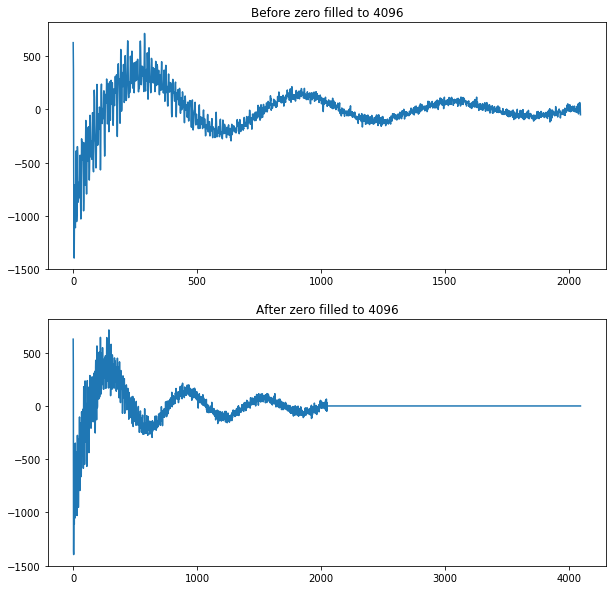

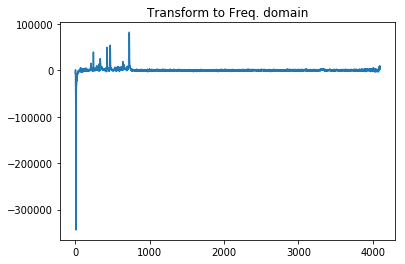

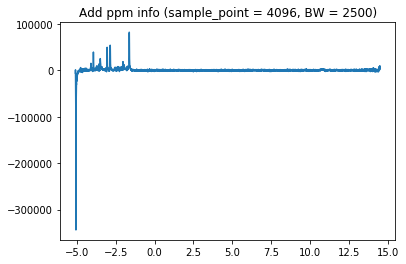

In [40]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('Before zero filled to 4096')
plt.plot(ws_tdata)#(2048,)

pad_ws_tdata = np.pad(ws_tdata[:,0], (0, 2048 - len(ws_tdata)%2048), 'constant')
plt.subplot(212)
plt.title('After zero filled to 4096')
plt.plot(pad_ws_tdata)#(2048,)

pad_ws_sdata = np.fft.fft(pad_ws_tdata)
plt.figure()
plt.title('Transform to Freq. domain')
plt.plot(pad_ws_sdata)#(2048,)
########################
sample_point = 4096#NDATAB =
BW = 2500#2000?
B = 127.75
ppm_length = BW/B#16.xx ppm
ppm_center = 4.7
min_bound = ppm_center - (ppm_length)/2
max_bound = ppm_center + (ppm_length)/2
ppm = np.linspace(min_bound, max_bound, sample_point)
#ppm = ppm[::-1]#reverse
########################
plt.figure()
plt.title('Add ppm info (sample_point = 4096, BW = 2500)')
plt.plot(ppm,pad_ws_sdata)#(2048,)